In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)
# See bottom for some explanations

In [2]:
LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [3]:
# Define Dataset, I know it is already on Pytorch but that's how we learn!
import os
import gzip
from torch.utils.data import Dataset, DataLoader

class FashionDataset:
    def __init__(self, X_filename, Y_filename):
        self.X = torch.Tensor(self.fetch_data(X_filename)[0x10:].reshape(-1, 28, 28))
        self.Y = torch.Tensor(self.fetch_data(Y_filename)[0x8:])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def fetch_data(self, filename):
        path = os.path.join("data", "fashion", filename)
        if not os.path.isdir("data/fashion"):
            os.makedirs("data/fashion", exist_ok=True)
        if not os.path.isfile(path):
            import requests
            url = f"http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/{filename}"
            data = requests.get(url).content
            with open(path, "wb") as f:
                f.write(data)
        else:
            with open(path, "rb") as f:
                data = f.read()
        return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [4]:
BS = 64

training_data = FashionDataset("train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz")
testing_data = FashionDataset("t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz")

train_dataloader = DataLoader(training_data, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BS, shuffle=True)


In [5]:
from torch import nn
import torch.nn.functional as F

class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        self.l1 = nn.Linear(16 * 4 * 4, 120) # Image will be of shape 16, 4, 4 after above ops
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)
        
    def forward(self, X):
        x = F.max_pool2d(F.relu(self.conv1(X)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.relu(self.l1(torch.flatten(x, 1)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, Y) in enumerate(dataloader):
        pred = model(X.reshape(-1, 1, 28, 28))
        loss = loss_fn(pred, Y.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X.reshape(-1, 1, 28, 28))
            test_loss += loss_fn(pred, Y.long()).item()
            correct += (pred.argmax(1) == Y).float().sum().item()

    test_loss /= num_batches
    correct /= size
    return correct, test_loss

In [24]:
from tqdm import trange
EPOCHS = 10

model = FashionMNISTNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in (t:=trange(EPOCHS)):
#     print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, avg_loss = test(test_dataloader, model, loss_fn)
    t.set_description(f"Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}")

Accuracy: 89.2%, Avg loss: 0.324496: 100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Prediction: Dress
Real: Dress


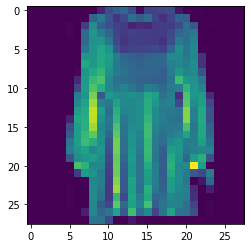

In [27]:
sample = np.random.randint(10000)
plt.imshow(testing_data[sample][0])
pred = model(testing_data[sample][0].reshape(-1, 1, 28, 28))
print(f"Prediction: {LABELS[pred.argmax().item()]}")
print(f"Real: {LABELS[testing_data[sample][1].item()]}")

T-shirt/top


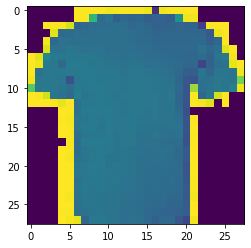

In [26]:
import cv2

img = cv2.imread("data/tshirt.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.resize(img, (28, 28)) - 255
plt.imshow(img)

pred = model(torch.Tensor(img.reshape(-1, 1, 28, 28)))
print(LABELS[pred.argmax().item()])

[Source](https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/)


**Padding**: append a border of zeros in order to not change the size
![Padding](https://editor.analyticsvidhya.com/uploads/99433dnn4.gif)

**Stride**: Some times we do not want to capture all the data or information available so we skip some 
        neighboring cells
![Stride](https://editor.analyticsvidhya.com/uploads/92373dnn5.gif)

**Pooling**: In general terms pooling refers to a small portion, so here we take a small portion of the input and try to take some summarized value
![Pooling](https://editor.analyticsvidhya.com/uploads/54575dnn6.png)